In [1]:
import torch
import numpy as np

from bmadx import Particle, Drift, Quadrupole
from bmadx import track_element, track_lattice, track_lattice_save_stats, track_lattice_save_particles
from bmadx import M_ELECTRON

from scalene import scalene_profiler

In [2]:
# Initial beam distribution

mean = torch.zeros(6)
cov = torch.diag(torch.tensor([1e-6, 2e-6, 3e-6, 2e-6, 1e-6, 2e-6]))
torch.manual_seed(0)
dist = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)

def create_beam(n_particles):
    coords = dist.sample(torch.Size([n_particles])) # particles' coordinates

    return Particle(*coords.T,
                    s=torch.tensor(0.),
                    p0c=torch.tensor(4e7),
                    mc2=M_ELECTRON)

In [3]:
def create_fodo(n_cells, l_d, l_q, k):
    q_f = Quadrupole(L = l_q, K1 = k)
    q_d = Quadrupole(L = l_q, K1 = -k)
    d = Drift(L = l_d)
    half_d = Drift(L = l_d/2)
    lat = []
    for i in range(n_cells):
        lat.extend([half_d, q_f, d, half_d, q_d])
    return lat

In [4]:
lat = create_fodo(10, 0.9, 0.1, 10)

In [5]:
N = 5
n_particles = np.logspace(0, N, N+1, dtype=int)
n_particles

array([     1,     10,    100,   1000,  10000, 100000])

In [6]:
from time import perf_counter

time_counter = perf_counter
t_no_save = []
t_save_par = []
t_save_stats = []
for n_par in n_particles:
    print(n_par)
    
    beam = create_beam(n_par)
    
    p_out = None
    t_0_no_save = time_counter()
    p_out = track_lattice(beam, lat)
    t_f_no_save = time_counter()
    t_no_save.extend([t_f_no_save - t_0_no_save])
    
    p_out = None
    t_0_save_par = time_counter()
    p_out = track_lattice_save_particles(beam, lat)
    t_f_save_par = time_counter()
    t_save_par.extend([t_f_save_par - t_0_save_par])
    
    p_out = None
    t_0_save_stats = time_counter()
    p_out = track_lattice_save_stats(beam, lat)
    t_f_save_stats = time_counter()
    t_save_stats.extend([t_f_save_stats - t_0_save_stats])

1
10
100
1000
10000
100000


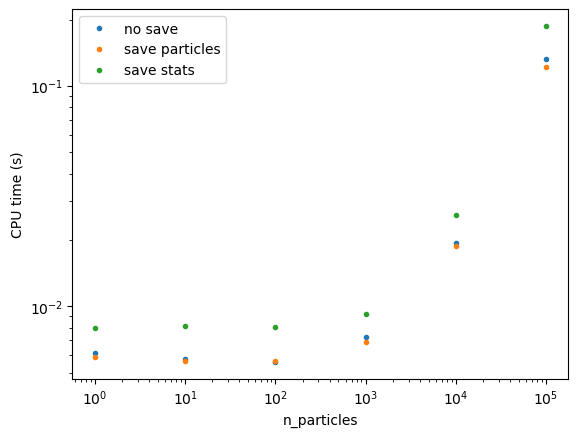

In [7]:
import matplotlib.pyplot as plt
plt.plot(n_particles, np.array(t_no_save), '.', label='no save')
plt.plot(n_particles, np.array(t_save_par), '.', label='save particles')
plt.plot(n_particles, np.array(t_save_stats), '.', label='save stats')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('n_particles')
plt.ylabel('CPU time (s)')
plt.legend()

In [10]:
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.

NOTE: in Jupyter notebook on MacOS, Scalene cannot profile child
processes. Do not run to try Scalene with multiprocessing in Jupyter
Notebook.


In [16]:
%scrun slow_function()
def slow_function():
    import time
    time.sleep(3)